### Step 4.2: Visualizing station clustering

__Step goals:__ Visualize obtained station clusters of over time and space.

__Step overview:__
1. Load the data;
2. Visualize clusters as set of time-series data;
3. Visualize station clusters on map;
4. Explore obtained clustering parameters.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px

from src.visualization.visualize import plot_counts 
plt.style.use('science')

In [5]:
matplotlib.rcParams['font.size']

10.0

In [6]:
font = {'size' : 12}
matplotlib.rc('font', **font)

1. Load the data

In [17]:
data_type = 'entry'

gdf = gpd.read_file(f'../data/interim/counts/{data_type}_station.json')
gdf = gdf.rename({'station' : 'station_name'}, axis=1)

# !!!: The sorting is essential to match labels with stations since the clustering was done on sorted data
gdf = gdf.sort_values('station_name').reset_index(drop=True)

n_components = 6
labels = np.load(f"../data/interim/gmm/stations/labels_{data_type}.npy", allow_pickle=True)[()][n_components]

print(f'Selected number of clusters : {n_components}')

Selected number of clusters : 6


In [18]:
# Assign labels to the stations
gdf['label'] = labels

# Create "meaningful" names for the labels
gdf['label_name'] = gdf['label']

label_names = ["Inner residential", "Polycentre", "CBD", "Mixed commuting", "Outer residential", "Potential feeder"]
# label_names = ["Mixed commuting", "CBD", "Potential feeder", "Inner residential", "Outer residential", "Polycenter"]

label_ids = [_ for _ in range(0, n_components)]

print(f'Cluster names are : {label_names}')

# Rename ids with names
gdf['label_name'].replace({0 : 'Inner residential', 1 : 'Polycentre', 
                           2 : 'CBD', 3 : 'Mixed commuting',
                           4 : 'Outer residential', 5 : 'Potential feeder'},
                           inplace=True)

Cluster names are : ['Inner residential', 'Polycentre', 'CBD', 'Mixed commuting', 'Outer residential', 'Potential feeder']


In [19]:
exit_stations = pd.read_csv('../data/interim/counts/Ex17week.csv')

In [20]:
# Define label names and corresponding colors
label_names = ["Inner residential", "Polycentre", "CBD", "Mixed commuting", "Outer residential", "Potential feeder"]
label_color_map = {"Outer residential": "#FF2C00", "CBD": "#00B945", "Polycentre": "#845B97", 
                   "Inner residential": "#FF9500", "Potential feeder": "#0C5DA5", "Mixed commuting": "#474747"}

In [46]:
all_stations_exit[j].max().values > all_stations_exit[j].max().values 

array([False])

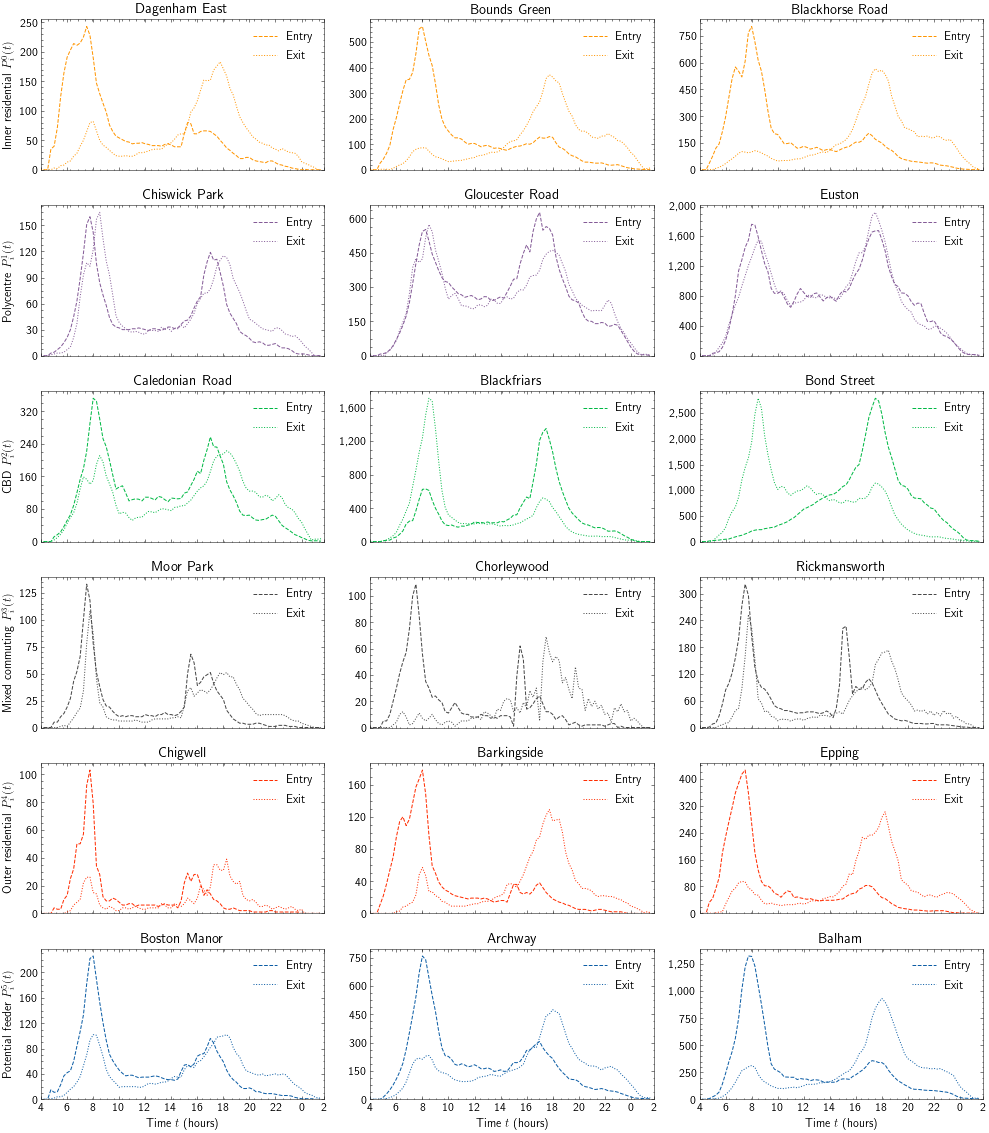

In [50]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=[14,16], sharex=True)

for i in range(6):
    current_label_name = gdf[gdf['label'] == i]['label_name'].iloc[0]
    current_label_stations = gdf[gdf['label'] == i]
    q10 = current_label_stations['total'].quantile(.1)
    q25 = current_label_stations['total'].quantile(.25)
    mean = current_label_stations['total'].mean()
    q75 = current_label_stations['total'].quantile(.75)
    
    q25_stations = current_label_stations[current_label_stations['total'] < q25]
    average_stations = current_label_stations[current_label_stations['total'] > mean - q10]
    average_stations = average_stations[average_stations['total'] < mean + q10]
    q75_stations = current_label_stations[current_label_stations['total'] > q75]
    
    q25_station_name = q25_stations['station_name'].tolist()[1]
    average_station_name = average_stations['station_name'].tolist()[1]
    q75_station_name = q75_stations['station_name'].tolist()[1]

    q25_station = pd.DataFrame(current_label_stations[current_label_stations['station_name'] == q25_station_name].loc[:,'0200-0215':'0145-0200']).T
    average_station = pd.DataFrame(current_label_stations[current_label_stations['station_name'] == average_station_name].loc[:,'0200-0215':'0145-0200']).T
    q75_station = pd.DataFrame(current_label_stations[current_label_stations['station_name'] == q75_station_name].loc[:,'0200-0215':'0145-0200']).T
    
    q25_station_exit = pd.DataFrame(exit_stations[exit_stations['station_name'] == q25_station_name].loc[:,'0200-0215':'0145-0200']).T
    average_station_exit = pd.DataFrame(exit_stations[exit_stations['station_name'] == average_station_name].loc[:,'0200-0215':'0145-0200']).T
    q75_station_exit = pd.DataFrame(exit_stations[exit_stations['station_name'] == q75_station_name].loc[:,'0200-0215':'0145-0200']).T
    
    q25_station.plot(ax=ax[i, 0], legend=False, color=label_color_map[current_label_name], linestyle='--', label='Entry')
    average_station.plot(ax=ax[i, 1], legend=False, color=label_color_map[current_label_name], linestyle='--', label='Entry')
    q75_station.plot(ax=ax[i, 2], legend=False, color=label_color_map[current_label_name], linestyle='--', label='Entry')
    
    q25_station_exit.plot(ax=ax[i, 0], legend=False, color=label_color_map[current_label_name], linestyle=':', label='Exit')
    average_station_exit.plot(ax=ax[i, 1], legend=False, color=label_color_map[current_label_name], linestyle=':', label='Exit')
    q75_station_exit.plot(ax=ax[i, 2], legend=False, color=label_color_map[current_label_name], linestyle=':', label='Exit')
    
    x_ticks = [0, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 96]
    x_ticks_labels = ["2","4","6","8","10","12","14","16","18","20","22","0","2"]
    
    all_stations_entry = [q25_station, average_station, q75_station]
    all_stations_exit = [q25_station_exit, average_station_exit, q75_station_exit]
    
    for j in range(0, 3):
        ax[i, j].set_xticks(x_ticks)
        ax[i, j].set_xticklabels(x_ticks_labels)
        ax[i, j].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
        ax[i, j].set_xlim(9, 96)
        
#         if all_stations_entry[j].max().values > all_stations_exit[j].max().values:
#             start, end = min(all_stations_entry[j].min()), max(all_stations_entry[j].max())
#         else:
#             start, end = min(all_stations_exit[j].min()), max(all_stations_exit[j].max())
            
#         ax[i, j].yaxis.set_ticks(np.arange(start, end + (end - start) / 5, (end - start) / 5))
        ax[i, j].yaxis.set_major_locator(plt.MaxNLocator(6))
        ax[i, j].legend(['Entry', 'Exit'])
        ax[i, j].set_xlabel("Time $t$ (hours)")
        ax[i, j].set_ylim(0)

    ax[i, 0].set_title(q25_station_name)
    ax[i, 1].set_title(average_station_name)
    ax[i, 2].set_title(q75_station_name)
    
    ax[i, 0].set_ylabel(fr'{current_label_name} $P_i^{i}(t)$')

fig.tight_layout()
fig.savefig('../figures/sfig8.png')

2. Plot stations clusters as time series

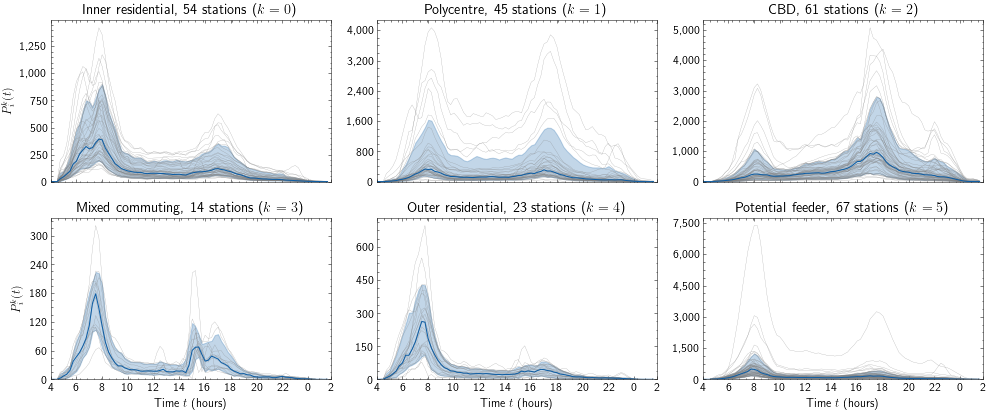

In [52]:
plot_counts(gdf, labels, n_components, label_names=label_names, plot_median=True, sharex=True, savefig=True, figsize=(14,6))

3. Plot station clusters as map

In [6]:
# Add lat and lon collumns for plotting with Plotly
lon = [point.x for point in gdf['geometry'].tolist()]
lat = [point.y for point in gdf['geometry'].tolist()]
gdf['lat'] = lat
gdf['lon'] = lon

# Save resulting data frame for reusage
gdf.to_file('../data/interim/counts/entry_station_cluster.json', driver='GeoJSON')

In [88]:
# Define API Key
api_key = ""

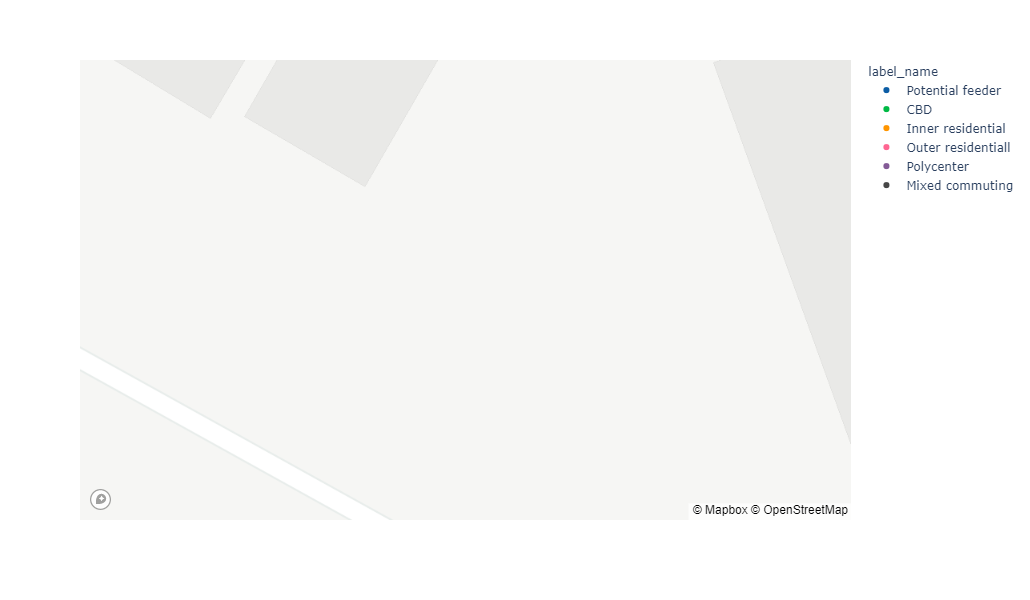

In [89]:
px.set_mapbox_access_token(api_key)
fig = px.scatter_mapbox(gdf, lat="lat", lon="lon", color="label_name", color_discrete_map={
    "Outer residential": "#FF2C00",
    "CBD": "#00B945",
    "Polycenter": "#845B97",
    "Inner residential": "#FF9500",
    "Potential feeder": "#0C5DA5",
    "Mixed commuting": "#474747",
    },
    # size="total",
    hover_data=['station_name'],
    zoom=9,
    width=1000,
    height=600,
)
fig.show()
# fig.write_image("../figures/entry_station_cluster_map.svg")

4. Explore cluster parameters 

In [90]:
probs = np.load(f"../data/interim/gmm/stations/probs_{data_type}.npy", allow_pickle=True)[()][n_components]
means = np.load(f"../data/interim/gmm/stations/means_{data_type}.npy", allow_pickle=True)[()][n_components]
covariances = np.load(f"../data/interim/gmm/stations/covariances_{data_type}.npy", allow_pickle=True)[()][n_components]
weights = np.load(f"../data/interim/gmm/stations/weights_{data_type}.npy", allow_pickle=True)[()][n_components]

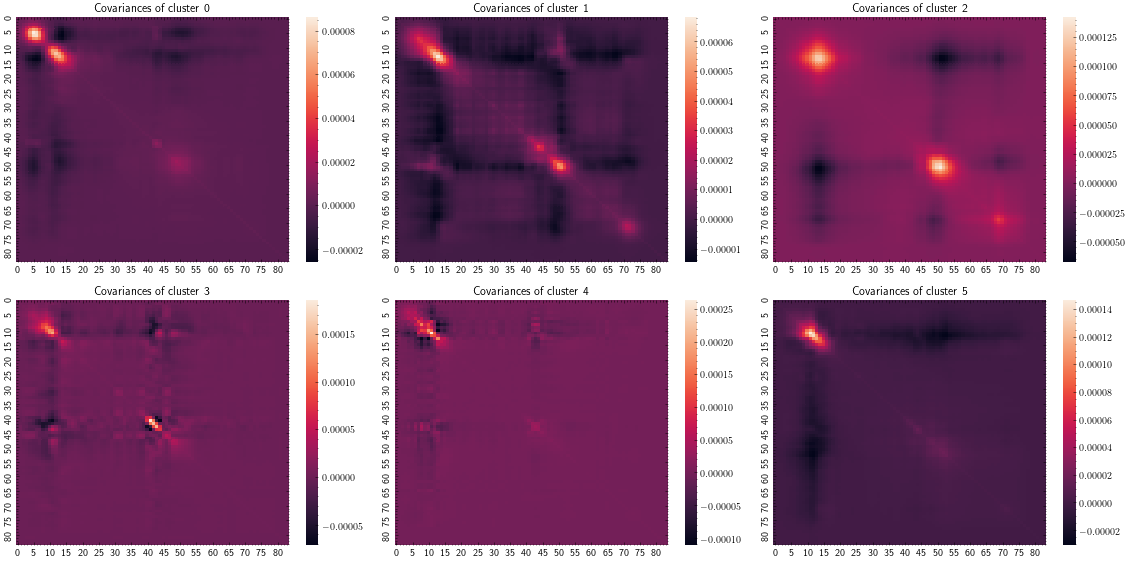

In [91]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(16,8))
k = 0
for i in range(0, 2):
    for j in range(0, 3):
        sns.heatmap(covariances[k], ax=ax[i,j])
        ax[i, j].set_title(f'Covariances of cluster {k}')
        k += 1
fig.tight_layout();
# plt.savefig('../figures/covariances.png', dpi=300)

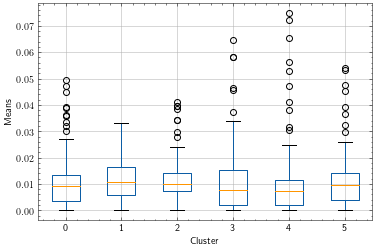

In [92]:
pd.DataFrame(means).T.boxplot()
plt.xlabel('Cluster')
plt.ylabel('Means');
# plt.savefig('../figures/boxplot.eps', dpi=300);

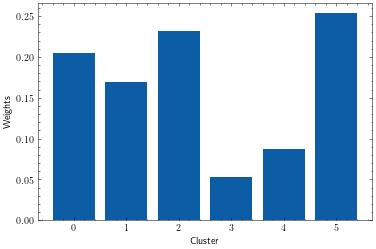

In [93]:
plt.bar(np.arange(0, n_components), weights)
plt.xlabel('Cluster')
plt.ylabel('Weights');
# plt.savefig('../reports/figures/weights.eps', dpi=300);

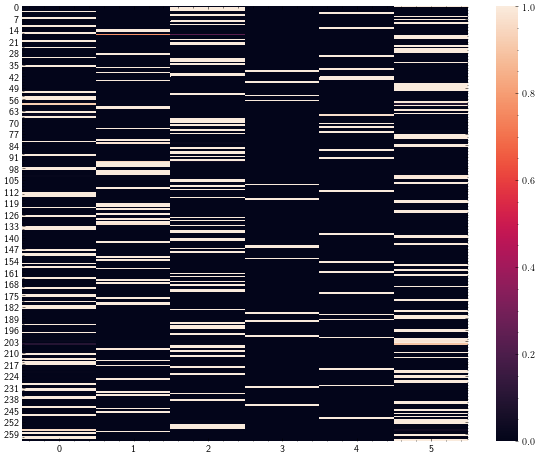

In [94]:
# In case of 6 stations the assignment of a cluster wasn't binary "enough"
fig = plt.figure(figsize=(10,8))
sns.heatmap(probs);

In [95]:
# Check where assignment of a clustrer wasn't exact (!=0 or !=1)
non_binary = []
for i in range(0, probs.shape[0]):
    for j in range(0, probs.shape[1]):
        if probs[i, j] != 1 and probs[i, j] != 0:
            non_binary.append(i)
            break

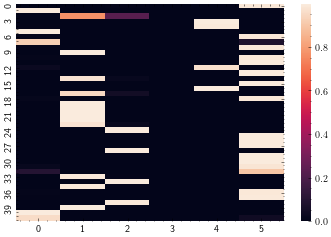

In [96]:
sns.heatmap(probs[non_binary,:]);

In [9]:
from haversine import haversine

In [10]:
entry_station_cluster = gpd.read_file('../data/interim/counts/entry_station_cluster.json')
df = pd.DataFrame(index=entry_station_cluster['station_name'].tolist(), columns=entry_station_cluster['station_name'].tolist())
df = df.fillna(0)

In [11]:
from tqdm import tqdm

In [12]:
n = entry_station_cluster.shape[0]

In [13]:
d = {}
k_max = 6
for k in range(0, k_max):
    d[k] = entry_station_cluster[entry_station_cluster['label'] == k]['station_name'].tolist()

In [14]:
from tqdm import tqdm

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:46<00:00, 27.75s/it]


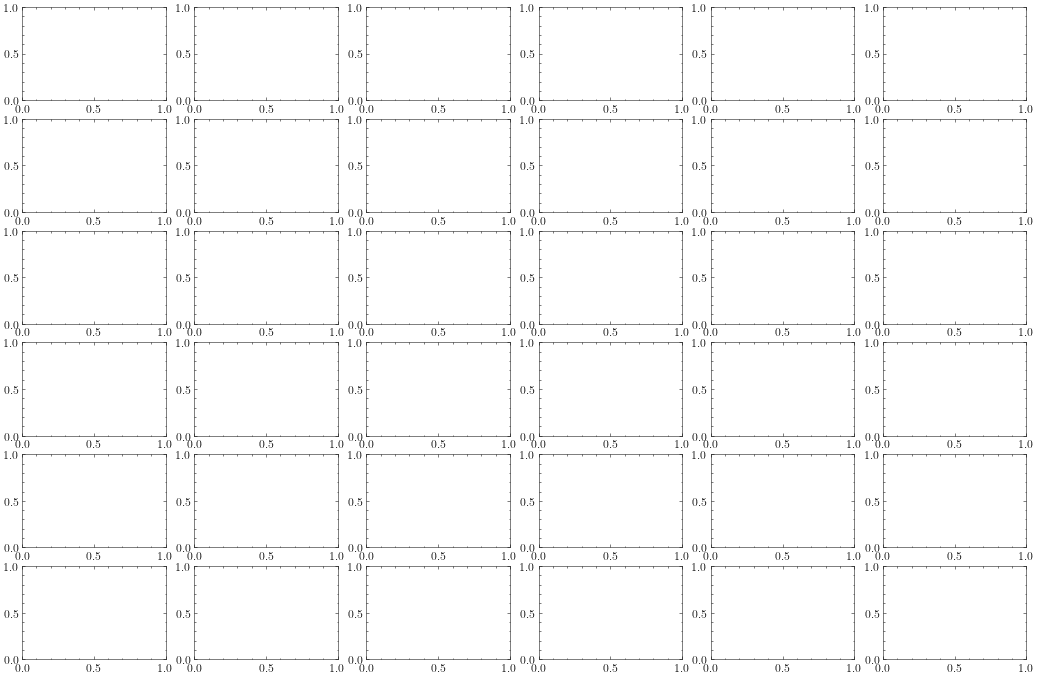

In [15]:
df = pd.DataFrame(index=np.arange(0,6), columns=np.arange(0,6))
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(18,12))
for i in tqdm(range(0, k_max)):
    stationsi = d[i]
    for j in range(0, k_max):
        stationsj = d[j]
        dist_list = []
        for si in stationsi:
            loni = entry_station_cluster[entry_station_cluster['station_name'] == si].loc[:, 'lon']
            lati = entry_station_cluster[entry_station_cluster['station_name'] == si].loc[:, 'lat']
            stationi = (loni, lati) 
            for sj in stationsj:
                lonj = entry_station_cluster[entry_station_cluster['station_name'] == sj].loc[:, 'lon']
                latj = entry_station_cluster[entry_station_cluster['station_name'] == sj].loc[:, 'lat']
                stationj = (lonj, latj) 
                dist = haversine(stationi, stationj)
                dist_list.append(dist)
        df.iloc[i,j] = dist_list

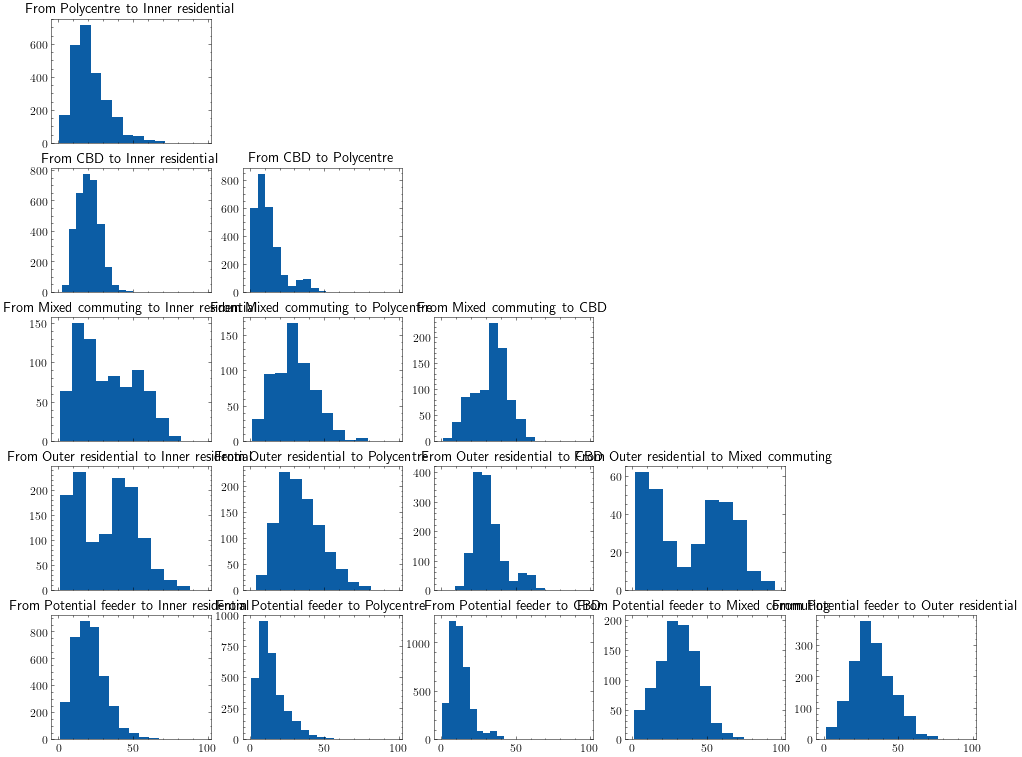

In [26]:
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(20,16), sharex=True)
j_min = -1
j_max = 4

for i in range(1, 6):
    for j in range(0, 6):
        ax[i, j].hist(df.iloc[i,j])
        ax[i, j].set_title(f'From {label_names[i]} to {label_names[j]}')
        # ax[i, j].set_xlabel('Haversine distance from station to station (km)')
        # ax[i, j].set_ylabel('Number of station pairs')
# fig.tight_layout()

for i in range(0, 6):
    j_max = 5
    while j_max > j_min:
        fig.delaxes(ax[i, j_max])
        j_max -= 1
    j_min += 1
# plt.savefig('../figures/sfig7.png', dpi=300)